In [140]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [141]:
def f(x):
    return 3*x**2 - 4*x + 5

In [142]:
f(3.0)

20.0

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
[345 284 229 180 137 100  69  44  25  12   5   4   9  20  37  60  89 124
 165 212 265]


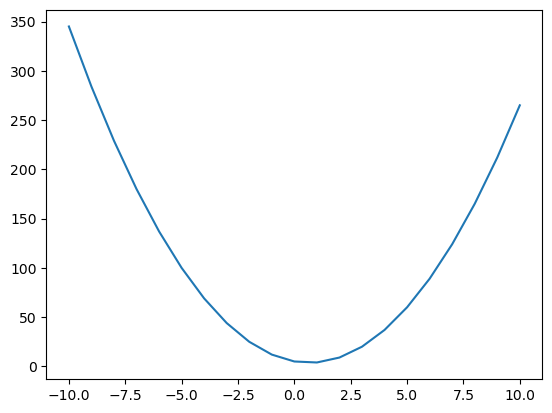

In [143]:
xs = np.arange(-10, 11, 1)
ys = f(xs)
print(xs)
print(ys)
plt.plot(xs, ys)

In [144]:
h = 0.0000001
x = 2/3
df = (f(x+h) - f(x))/h
print(df)

2.9753977059954195e-07


In [145]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [146]:
h = 0.0000001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 4.0000002
slope: 1.9999999967268423


In [179]:
class Value:
    def __init__(self, value, _children=(), _op='', label=''):
        self.value = value
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.value})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), '*')
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.value**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.value**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.value
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for v in reversed(topo):
            v._backward()


In [177]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e +c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

Value(data=4.0)

In [148]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    print(nodes)
    print(edges)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.value, n.grad), shape='record' )
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [149]:
'''
Chain rule is rule of three in rate perspective for example:
"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast as the man."
Car <--2x--- bicycle <--4x--- walking
Car <--??--- walking
?? = 2 x 4 = 8x

We can do the same with equations for example:
d = a + 4
a = 2 x c

If we want to know how c impact to d (dd/dc), we can visualize like this:
d <------ a <-------- c
Next we need to find rate of c to a and a to d.
a = 2 x c
da/dc = 2 x 1
      = 2

d = a + 4
dd/da = 1 + 0
      = 1

so now that we know the rate:
d <---1x-- a <---2x-- c
dd/dc = da/dc x dd/da = 1 x 2 = 2
'''

'\nChain rule is rule of three in rate perspective for example:\n"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast as the man."\nCar <--2x--- bicycle <--4x--- walking\nCar <--??--- walking\n?? = 2 x 4 = 8x\n\nWe can do the same with equations for example:\nd = a + 4\na = 2 x c\n\nIf we want to know how c impact to d (dd/dc), we can visualize like this:\nd <------ a <-------- c\nNext we need to find rate of c to a and a to d.\na = 2 x c\nda/dc = 2 x 1\n      = 2\n\nd = a + 4\ndd/da = 1 + 0\n      = 1\n\nso now that we know the rate:\nd <---1x-- a <---2x-- c\ndd/dc = da/dc x dd/da = 1 x 2 = 2\n'

In [150]:
# dL/dL = 1
L.grad = 1.0

# dL/dd = dL/dL * dL/dd = 1 * f = f
d.grad = -2.0

# dL/df = dL/dL * dL/df = 1 * d = f
f.grad = 4

# dL/de = dL/dL * dL/dd * dd/de = 1 * f * 1 = f
e.grad = -2.0

# dL/dc = dL/dL * dL/dd * dd/dc = 1 * f * 1 = f
c.grad = -2.0

# dL/da = dL/dL * dL/dd * dd/de * de/da = 1 * f * 1 * b = f * b
a.grad = 6.0

# dL/db = dL/dL * dL/dd * dd/de * de/db = 1 * f * 1 * a = f * a
b.grad = -4.0

{Value(data=2.0), Value(data=-6.0), Value(data=-8.0), Value(data=-2.0), Value(data=10.0), Value(data=4.0), Value(data=-3.0)}
{(Value(data=10.0), Value(data=4.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=4.0), Value(data=-8.0)), (Value(data=-6.0), Value(data=4.0)), (Value(data=-2.0), Value(data=-8.0))}


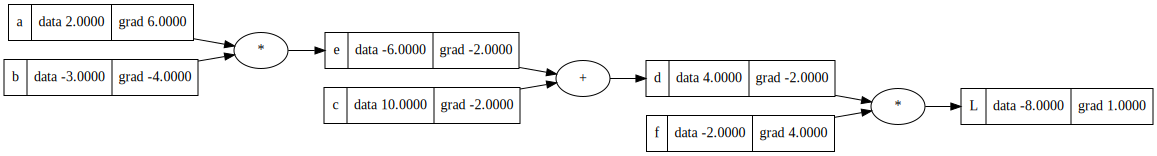

In [151]:
draw_dot(L)

In [152]:
def lol():
    h = 0.000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e +c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.value

    a = Value(2.0 +h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e +c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.value

    print('dL/de:', (L2-L1)/h)
lol()

dL/de: 6.000000000838668


In [153]:
# if we want to make L increase, we can increase every leaf node with valu in the direction of gradient
a.value += a.grad * 0.01
b.value += b.grad * 0.01
c.value += c.grad * 0.01
f.value += f.grad * 0.01
e = a*b
d = e + c
L = d*f
# L increase from -8.0 to -7.286
L.value

-7.286496

In [167]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.8813735870195432, label='b')
#  x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
y = x1w1x2w2 + b
y.label = 'y'
o = y.tanh()
o.label = 'o'


{Value(data=0.0), Value(data=0.8813735870195432), Value(data=-6.0), Value(data=1.0), Value(data=2.0), Value(data=-3.0), Value(data=0.0), Value(data=-6.0), Value(data=0.7071067811865476), Value(data=6.881373587019543)}
{(Value(data=2.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=1.0), Value(data=0.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=0.0), Value(data=0.0)), (Value(data=0.8813735870195432), Value(data=0.7071067811865476))}


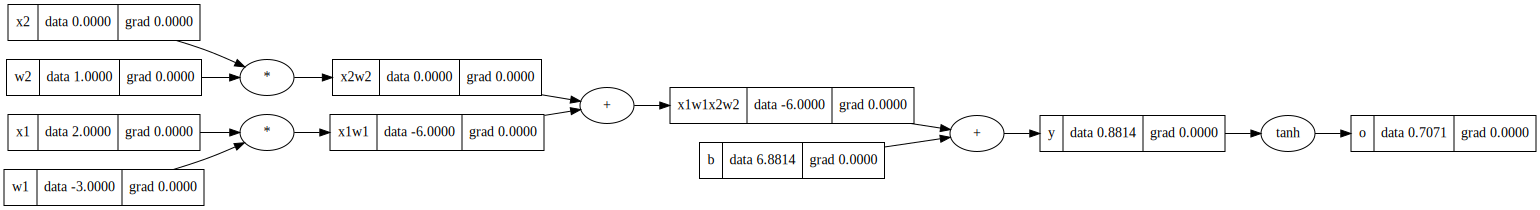

In [155]:
draw_dot(o)

In [156]:
# # backpropagation with hand
# o.grad = 1.0
# # do/dy = 1-tanh^2(y)
# y.grad = (1-o.value**2)
# # do/dx1w1x2w2 = dy/dx1w1x2w2 * do/dy = 1 * (1-tanh^2(y))
# x1w1x2w2.grad = y.grad
# # do/db = dy/db * do/dy = 1 * (1-tanh^2(y))
# b.grad = y.grad
# # do/dx1w1 = do/dy * dy/dx1w1x2w2 * dx1w1x2w2/dx1w1 = (1-tanh^2(y)) * 1 * 1
# x1w1.grad = y.grad
# # do/dx2w2 = do/dy * dy/dx1w1x2w2 * dx1w1x2w2/dx2w2 = (1-tanh^2(y)) * 1 * 1 
# x2w2.grad = y.grad
# # do/dx1 = do/dy * dy/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dx1 = (1-tanh^2(y)) * 1 * 1 * w1
# x1.grad = y.grad * w1.value
# # do/dw1 = do/dy * dy/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dw1 = (1-tanh^2(y)) * 1 * 1 * x1
# w1.grad = y.grad * x1.value
# # do/dx2 = do/dy * dy/dx1w1x2w2 * dx1w1x2w2/dx2w2 * dx2w2/dx2 = (1-tanh^2(y)) * 1 * 1 * w2
# x2.grad = y.grad * w2.value
# # do/dw2 = do/dy * dy/dx1w1x2w2 * dx1w1x2w2/dx2w2 * dx2w2/dx2 = (1-tanh^2(y)) * 1 * 1 * x2
# w2.grad = y.grad * x2.value

In [157]:
# backpropagation with code
o.grad = 1.0
o._backward()
y._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()

In [159]:
# topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [168]:
# backpropagation with topological sort
o.backward()

{Value(data=-6.0), Value(data=0.8813735870195432), Value(data=-6.0), Value(data=2.0), Value(data=0.0), Value(data=0.7071067811865476), Value(data=6.881373587019543), Value(data=1.0), Value(data=-3.0), Value(data=0.0)}
{(Value(data=0.8813735870195432), Value(data=0.7071067811865476)), (Value(data=0.0), Value(data=0.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=1.0), Value(data=0.0)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0))}


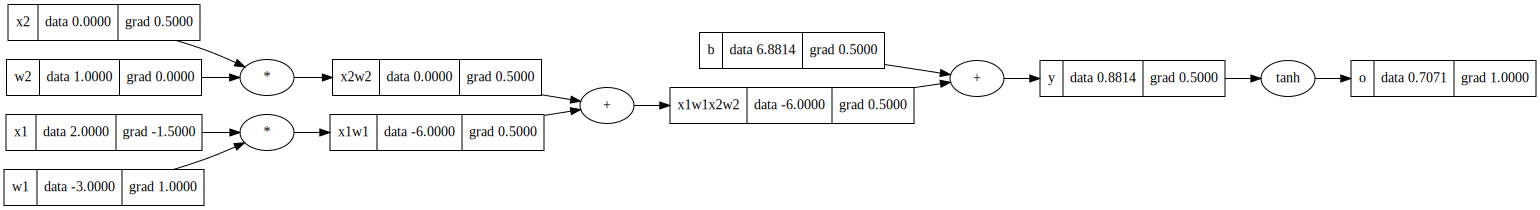

In [169]:
draw_dot(o)

{Value(data=6.0), Value(data=3.0)}
{(Value(data=3.0), Value(data=6.0))}


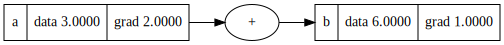

In [171]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

{Value(data=1.7627471740390863), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.7071067811865477), Value(data=0.0), Value(data=0.1464466094067262), Value(data=6.828427124746192), Value(data=2.0), Value(data=-1), Value(data=5.828427124746192), Value(data=-6.0), Value(data=-3.0), Value(data=1), Value(data=0.8813735870195432), Value(data=6.881373587019543), Value(data=4.828427124746192), Value(data=2)}
{(Value(data=-6.0), Value(data=-6.0)), (Value(data=6.828427124746192), Value(data=0.1464466094067262)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=0.0), Value(data=0.0)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=0.1464466094067262), Value(data=0.7071067811865477)), (Value(data=1.7627471740390863), Value(data=5.828427124746192)), (Value(data=1), Value(data=6.828427124746192)), (Value(data=5.828427124746192), Value(data=6.828427124746192)), (Value(data=-1), Value(data=4.828427124746192)), (Value(

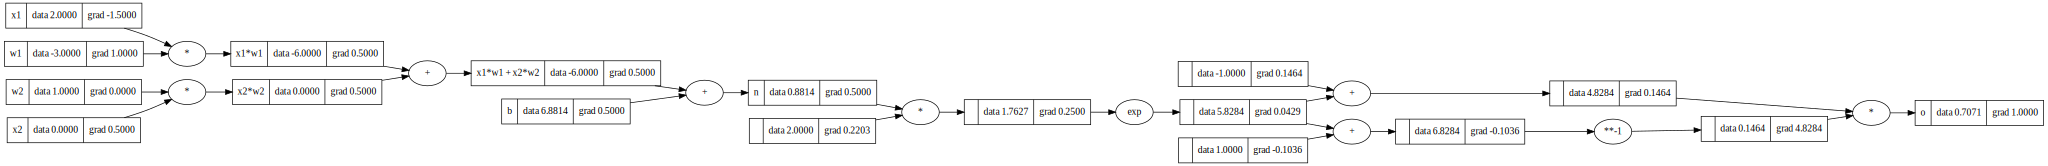

In [180]:
# nerual network without tanh fucntion
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [181]:
import torch

In [189]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()
print('------------')
print('x1:', x1.grad.item())
print('x2:', x2.grad.item())
print('w1:', w1.grad.item())
print('w2:', w2.grad.item())


0.7071066904050358
------------
x1: -1.5000003851533106
x2: 0.5000001283844369
w1: 1.0000002567688737
w2: 0.0
